In [115]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

In [3]:
csv_file = 'data/HeartRateData.csv'
df = pd.read_csv(csv_file)
df.head()
df=df.drop('DateTime',1)
df.head()

,BPM
0,77
1,69
2,69
3,69
4,69


In [4]:
df.BPM.describe()

count    349768.000000
mean         77.648204
std          23.626089
min          30.000000
25%          61.000000
50%          69.000000
75%          86.000000
max         215.000000
Name: BPM, dtype: float64

In [5]:
def zones(df, age):
    max_hr = 220 - age
    target_low = 0.64*max_hr
    target_high = 0.76*max_hr
    target_intensity_lo = 0.76*max_hr
    target_intensity_hi = 0.93*max_hr
    print ("For Age: {} Maximum HR: {}".format(age,max_hr))
    print ("Target HR Lower Bound:", target_low)
    print ("Target HR Upper Bound:", target_high)
    print ("Target HR Intensity Upper Bound:", target_intensity_hi)
    return max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi

In [6]:
max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi = zones(df,62)

For Age: 62 Maximum HR: 158
Target HR Lower Bound: 101.12
Target HR Upper Bound: 120.08
Target HR Intensity Upper Bound: 146.94


In [7]:
def plot_data_histo(totals): 
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    plt.grid(True)
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Heart Rate Distribution')
    plt.hist(df.BPM,50)
    plt.show()

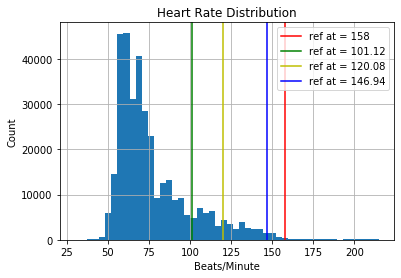

In [8]:
#print (df.BPM)
plot_data_histo(df.BPM)

In [151]:
def scree_KMeans_plot(data,num_clusters):
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        print ("Cluster Label: ",labels)
        score = -(kmeans.score(data))
        print ("score: ",score/100000000)
        scores.append(score)
    print ("scores: ",scores )
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels


Cluster 1: [[77.64820395]]
Cluster Label:  [0 0 0 ... 0 0 0]
score:  1.95237173551723

Cluster 2: [[ 67.75020615]
 [117.47091011]]
Cluster Label:  [0 0 0 ... 0 0 1]
score:  0.5737084950402145

Cluster 3: [[ 63.25309656]
 [129.08728976]
 [ 87.99679777]]
Cluster Label:  [2 0 0 ... 0 0 1]
score:  0.3054380885981595

Cluster 4: [[103.414389  ]
 [ 61.48358498]
 [138.55663645]
 [ 78.29681967]]
Cluster Label:  [3 1 1 ... 1 1 2]
score:  0.1919105212269045
scores:  [195237173.551723, 57370849.50402145, 30543808.85981595, 19191052.12269045]


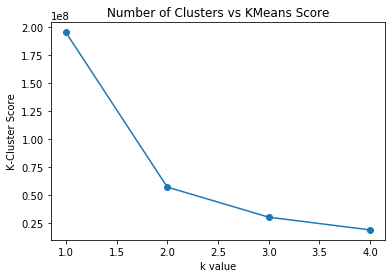


Function in 0.1 minutes


In [155]:
k_values, scores, labels = scree_KMeans_plot(df,5) 
k = zip(k_values, scores)
print (k)

In [153]:
x=labels
oftype(labels)
if isinstance(x,list):
        print ("List")
  
print (labels)
np.unique(labels)

numpy (349768,)
[6 1 1 ... 1 1 4]


array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [89]:
scores_1E8 = [] 
for score in scores:
    scores_1E8.append(score/100000000)
scores_1E8

[1.95237173551723,
 0.5737084950402145,
 0.3054380885981595,
 0.18983188620401523,
 0.13594165256442528,
 0.09018768364450168,
 0.06616339847613856,
 0.05024936386329572,
 0.040461319409733604,
 0.03282647601760699,
 0.028922767197097556,
 0.023698337504489884,
 0.021102467920565443,
 0.017813945811622767,
 0.015040609348080745,
 0.013432169584281664,
 0.011757957017291841,
 0.01091934613564488,
 0.009341136042500232]

In [130]:
def findK(df,limit): 
    for k in range(len(df)):
        if k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          if improvement < limit:
                break 
    print ("{}% improvement limit reached at k = {}".format(limit,k))
findK(scores_1E8,10)      

10% improvement limit reached at k = 17


In [11]:
def silhouetteScore(df): 
    start = timer()
    range_n_clusters = list(range(2,7))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        print(f"\nFunction in {(end - start)/60:0.1f} minutes")

In [12]:
#silhouetteScore(df)

For n_clusters = 2, silhouette score is 0.7042516317444071

Function in 30.5 minutes
For n_clusters = 3, silhouette score is 0.6140819352176045

Function in 62.6 minutes
For n_clusters = 4, silhouette score is 0.58831778833054

Function in 123.2 minutes
For n_clusters = 5, silhouette score is 0.5563375366485069

Function in 154.2 minutes
For n_clusters = 6, silhouette score is 0.5654972784167175

Function in 184.0 minutes


In [13]:
# Maximum Heart Rate: 200 - 1/2 age. Harvard Health News 
#Target Heart Rate Zone: 60%-75%. 70 yr old max would be 165 and target of 99 to 124. Harvard Health News.
# Maxiumum Heart Rate is 200 - Age. CDC. 
# Target Heart Rate is 64% to 76%. CDC. 
# Intenisty target heart rate is 77% to 93%. CDC. 
# Polar.com: 
# 5 Zones. 1: very light at 60-70% of HRMAX. Boost recovery, 
#2: light at 60-70% improve general endurance and increase capillary density. , 
#3:moderate at 70-80%.Lactic acid build up, improve efficiency of blood circulation in the heart and muscles
#4: Hard 80-90%, 5: Maximum 90-100%. 
#5 - improve speed endurance. 

In [14]:
def silhotteScore(df): 
    range_n_clusters = list(range(2,7))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

In [156]:
#Count number in each cluster for general population 
clusterDict = collections.Counter(labels)
#print (clusterDict)

customerClusterSum = sum(clusterDict.values())

for key,value in sorted(clusterDict.items()): 
    print (key, ' ->',np.round(100*value/customerClusterSum,2),'%')

0  -> 14.39 %
1  -> 51.69 %
2  -> 7.35 %
3  -> 26.56 %
